# MODELE CNN

# Library imports et Configurations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
#from torchsummary import summary

from PIL import Image
import os

from torchvision.datasets import ImageFolder
from PIL import Image
import os

from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile
import os
import random

from torchvision.datasets import ImageFolder
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Affichage des images

In [4]:
data_dir = "First_Trial"

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show_images(dataloader, num_images=6, num_channels=3, normalize=False):
    images, labels = next(iter(dataloader))  # (batch_size, C, H, W)

    # Adapter le nombre si le batch est plus petit
    num_images = min(num_images, images.shape[0])

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.5, 2.5))

    for i in range(num_images):
        image = images[i].numpy()  # (C, H, W)

        # Dénormaliser si demandé
        if normalize:
            image = image * 0.5 + 0.5  # si tes données étaient normalisées avec mean=0.5, std=0.5

        image = np.clip(image, 0, 1)

        if num_channels == 1:
            image = image.squeeze(0)
            axes[i].imshow(image, cmap='gray')
        else:
            image = np.transpose(image, (1, 2, 0))  # (H, W, C)
            axes[i].imshow(image)
        class_name = dataset.classes[labels[i]]
        axes[i].set_title(class_name, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Robustesse des données

In [ ]:
# Liste des images non-RGB
non_rgb_images = []

# Parcourir les sous-dossiers/classes
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp', '.tif', '.tiff')):
                try:
                    with Image.open(file_path) as img:
                        if img.mode != "RGB":
                            non_rgb_images.append((file_path, img.mode))
                except Exception as e:
                    print(f"Erreur avec {file_path} : {e}")

# Affichage
print(f"\n{len(non_rgb_images)} image(s) non-RGB found:")
for path, mode in non_rgb_images:
    print(f"{path} (mode : {mode})")



🧾 6 image(s) non-RGB found:
First_Trial/Oral Lichen Planus/3-10.png (mode : RGBA)
First_Trial/Oral Lichen Planus/Papular-type-lichen-planus-lateral-border-of-tongue.png (mode : P)
First_Trial/Leukoplakia /Screenshot 2025-11-03 at 1.46.03 AM.png (mode : RGBA)
First_Trial/Leukoplakia /20250630_155131.png (mode : RGBA)
First_Trial/Leukoplakia /2-181.png (mode : RGBA)
First_Trial/Leukoplakia /Screenshot 2025-11-03 at 1.46.41 AM.png (mode : RGBA)


# Data Preparation et Data Augmentation

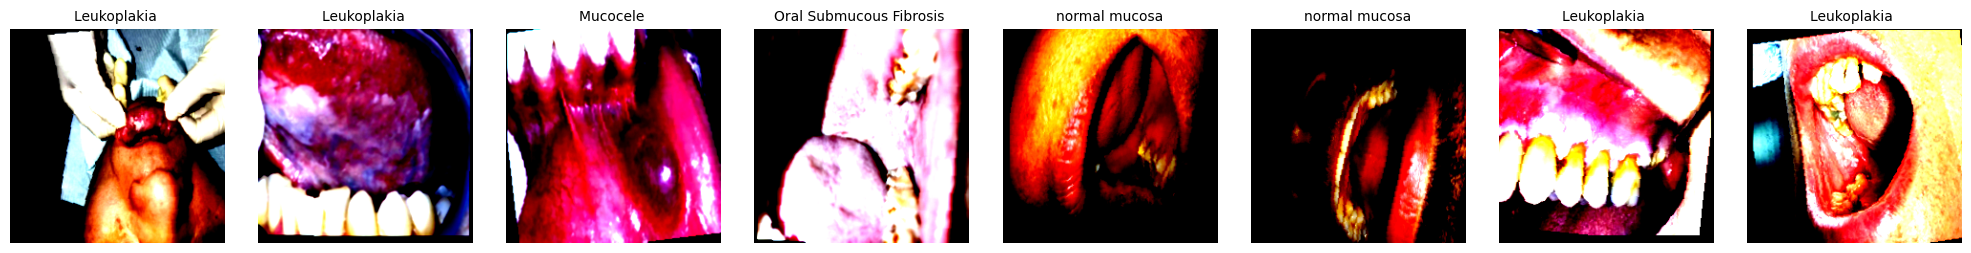

In [6]:
from torch.utils.data import random_split
# Custom ImageFolder qui convertit toutes les images en RGB
non_empty_classes = [
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d)) and
       len(os.listdir(os.path.join(data_dir, d))) > 0
]


# Autoriser le chargement d'images tronquées
ImageFile.LOAD_TRUNCATED_IMAGES = True

class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Filtrer les dossiers non vides uniquement
        classes = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d)) and len(os.listdir(os.path.join(directory, d))) > 0
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]

        try:
            img = Image.open(path)
        except (OSError, ValueError):
            # Si l'image est corrompue → on en prend une autre au hasard
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        # Gestion des modes P ou RGBA
        if img.mode == "P":
            img = img.convert("RGBA")

        if img.mode == "RGBA":
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])  # canal alpha
            img = background
        elif img.mode != "RGB":
            img = img.convert("RGB")

        # Appliquer la transformation (ToTensor etc.)
        if self.transform is not None:
            img = self.transform(img)

        return img, target


transform = transforms.Compose([
    transforms.Resize((225, 225)),

    # géométrie
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(225, scale=(0.9, 1.0)),

    # légères augmentations d'éclairage
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    # lissage léger
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),

    transforms.ToTensor(),

    # indispensable pour CNN
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
dataset = FilteredImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset)- train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
data_loader_train = DataLoader(train_dataset, batch_size=8, shuffle=True)
data_loader_test = DataLoader(test_dataset, batch_size=8, shuffle=True)
data_loader_val = DataLoader(val_dataset, batch_size=8, shuffle=True)

show_images(data_loader_train, num_images=10, num_channels=3)

In [28]:
img, label = train_dataset[8]
print(img.shape, label)


torch.Size([3, 600, 600]) 1


In [10]:
class LaplacianFilter:
    def __call__(self, img: Image.Image) -> Image.Image:
        # img is a PIL image (should be grayscale based on the pipeline)

        # Convert PIL image to NumPy array (typically uint8 for grayscale PIL)
        img_np = np.array(img) # PIL -> NumPy (shape H x W)

        # Check data type and convert to uint8 if necessary
        if img_np.dtype != np.uint8:
            # If input is not uint8 (e.g., from ToTensor resulting in float32 0-1),
            # scale it to 0-255 and convert to uint8.
            # This case is less likely if applied before ToTensor, but good practice.
            img_np = (img_np * 255).astype(np.uint8)

        # Apply the Laplacian filter.
        # We use cv2.CV_64F for calculation depth, then convert back to uint8.
        # The input img_np should be uint8 or float32. uint8 is safer here.
        laplacian = cv2.Laplacian(img_np, cv2.CV_64F)

        # Convert the absolute value of the Laplacian result to 8-bit (0-255)
        # This maps the potentially negative and positive filter responses
        # to a displayable intensity range.
        laplacian_abs = cv2.convertScaleAbs(laplacian)

        # Return a PIL image from the processed NumPy array
        return Image.fromarray(laplacian_abs)


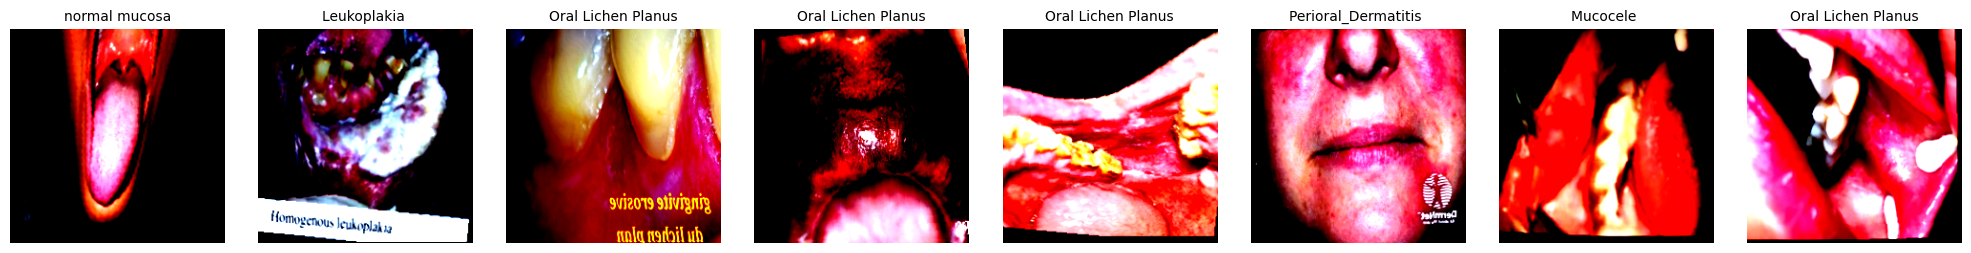

In [64]:
BATCH_SIZE = 8

augmented_transform = transforms.Compose([
    transforms.Resize((225, 225)),

    # géométrie
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(225, scale=(0.9, 1.0)),

    # légères augmentations d'éclairage
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    # lissage léger
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)),

    transforms.ToTensor(),

    # indispensable pour CNN
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_dataset = FilteredImageFolder(root=data_dir, transform=augmented_transform)

subset_indices_train = torch.randperm(len(train_dataset))
small_dataset_train = torch.utils.data.Subset(train_dataset, subset_indices_train)
data_loader_train = DataLoader(small_dataset_train, batch_size=BATCH_SIZE, shuffle=True)

images_train, labels_train = next(iter(data_loader_train))
show_images(data_loader_train, num_images=10, num_channels=3)

# Split dataset en Train / Validation / Test - 70 / 15 / 15

In [12]:
from sklearn.model_selection import train_test_split
# labels = dataset.classes # This line is not needed as labels are extracted from dataset_obj.samples
# data_dir = "/content/drive/MyDrive/ORALYZE/ORALYZE_Project_Secure/1_dataset/1_dataset_validation_images/ORALYZE_Prototype_Images/First_Trial" # This is not directly used for splitting as X

def split_dataset(dataset_obj, val_size=0.15, test_size=0.15):
    # Extract image paths and their corresponding class indices from the dataset object
    image_paths = [sample[0] for sample in dataset_obj.samples]
    image_labels = [sample[1] for sample in dataset_obj.samples] # These are integer class indices

    # Ensure that image_paths and image_labels have the same number of samples
    if len(image_paths) != len(image_labels):
        raise ValueError("Lengths of image_paths and image_labels must be consistent.")

    # Perform the first split: train, temp (val + test)
    # The 'stratify' argument should use the actual labels for each image
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, image_labels, test_size=val_size + test_size,
        stratify=image_labels, random_state=42
    )

    # Calculate the test ratio relative to the temp set
    # This ensures the validation and test sets maintain their desired proportions
    test_ratio_relative_to_temp = test_size / (val_size + test_size)

    # Perform the second split: val, test from the temp set
    # The 'stratify' argument should use the labels of the temporary set
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_ratio_relative_to_temp,
        stratify=y_temp, random_state=42
    )
    return X_train, y_train, X_val, y_val, X_test, y_test

# Call the function, passing the 'dataset' object
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataset_obj=dataset)

print(f"Total images: {len(dataset.samples)}")
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Total images: 1942
Train samples: 1359
Validation samples: 291
Test samples: 292


 # Architecture du modèle CNN

In [10]:
##
class Model1(nn.Module):
    def __init__(self, nb_classes):
        super().__init__()

        # --- BLOCK 1 ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 225 → 112

        # --- BLOCK 2 ---
        self.conv3 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.bn3   = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112 → 56

        # --- BLOCK 3 ---
        self.conv5 = nn.Conv2d(128, 160, kernel_size=3, padding='same')
        self.bn5   = nn.BatchNorm2d(160)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56 → 28

        # compute flatten size
        self._initialize_fc(nb_classes)

    def _initialize_fc(self, nb_classes):
        """Compute flatten size by passing dummy input through SAME forward pipeline"""
        with torch.no_grad():
            x = torch.zeros(1, 3, 225, 225)

            # === BLOCK 1 ===
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.pool1(x)

            # === BLOCK 2 ===
            x = F.relu(self.bn3(self.conv3(x)))
            x = F.relu(self.bn4(self.conv4(x)))
            x = self.pool2(x)

            # === BLOCK 3 ===
            x = F.relu(self.bn5(self.conv5(x)))
            x = self.pool3(x)

            flatten_dim = x.numel()

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, nb_classes)
        )

    def forward(self, x):

        # === BLOCK 1 ===
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # === BLOCK 2 ===
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # === BLOCK 3 ===
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Entrainement du modèle

In [8]:

from tqdm import tqdm
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    desc = f"Epoch {epoch}" if epoch is not None else "Training"
    pbar = tqdm(loader, desc=desc, ncols=120)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    desc = f"Val {epoch}" if epoch is not None else "Validation"

    pbar = tqdm(loader, desc=desc, ncols=120)

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## 50 epochs

Val 1: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.96it/s]


Epoch [1/50] - Train loss: 4.3157, train_acc: 22.09% - Val loss: 1.8870, val_cc: 30.77%


Val 2: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.74it/s]


Epoch [2/50] - Train loss: 1.8559, train_acc: 29.23% - Val loss: 1.6922, val_cc: 31.79%


Val 3: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.97it/s]


Epoch [3/50] - Train loss: 1.8174, train_acc: 30.52% - Val loss: 1.6981, val_cc: 38.46%


Val 4: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.59it/s]


Epoch [4/50] - Train loss: 1.7749, train_acc: 30.71% - Val loss: 1.6868, val_cc: 34.87%


Val 5: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.94it/s]


Epoch [5/50] - Train loss: 1.7536, train_acc: 32.84% - Val loss: 1.6935, val_cc: 38.46%


Val 6: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch [6/50] - Train loss: 1.7197, train_acc: 31.49% - Val loss: 1.5860, val_cc: 37.44%


Val 7: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch [7/50] - Train loss: 1.7271, train_acc: 33.48% - Val loss: 1.6263, val_cc: 38.46%


Val 8: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.84it/s]


Epoch [8/50] - Train loss: 1.6590, train_acc: 34.13% - Val loss: 1.6422, val_cc: 32.82%


Val 9: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.01it/s]


Epoch [9/50] - Train loss: 1.6966, train_acc: 34.84% - Val loss: 1.5965, val_cc: 42.05%


Val 10: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.97it/s]


Epoch [10/50] - Train loss: 1.6427, train_acc: 36.25% - Val loss: 1.5488, val_cc: 36.92%


Val 11: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch [11/50] - Train loss: 1.6361, train_acc: 37.15% - Val loss: 1.5148, val_cc: 43.08%


Val 12: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.04it/s]


Epoch [12/50] - Train loss: 1.5952, train_acc: 36.51% - Val loss: 1.6494, val_cc: 38.97%


Val 13: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch [13/50] - Train loss: 1.6006, train_acc: 39.02% - Val loss: 1.5954, val_cc: 34.87%


Val 14: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.15it/s]


Epoch [14/50] - Train loss: 1.5836, train_acc: 38.70% - Val loss: 1.5162, val_cc: 43.08%


Val 15: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.96it/s]


Epoch [15/50] - Train loss: 1.5205, train_acc: 40.57% - Val loss: 1.4744, val_cc: 46.67%


Val 16: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch [16/50] - Train loss: 1.5905, train_acc: 38.12% - Val loss: 1.4919, val_cc: 40.51%


Val 17: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.87it/s]


Epoch [17/50] - Train loss: 1.5206, train_acc: 40.12% - Val loss: 1.5246, val_cc: 45.64%


Val 18: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.86it/s]


Epoch [18/50] - Train loss: 1.5051, train_acc: 42.11% - Val loss: 1.4786, val_cc: 42.56%


Val 19: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.08it/s]


Epoch [19/50] - Train loss: 1.4824, train_acc: 41.27% - Val loss: 1.4196, val_cc: 42.56%


Val 20: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.87it/s]


Epoch [20/50] - Train loss: 1.4666, train_acc: 42.76% - Val loss: 1.4335, val_cc: 41.03%


Val 21: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.08it/s]


Epoch [21/50] - Train loss: 1.4889, train_acc: 42.11% - Val loss: 1.5271, val_cc: 48.21%


Val 22: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.81it/s]


Epoch [22/50] - Train loss: 1.4426, train_acc: 44.17% - Val loss: 1.3647, val_cc: 49.23%


Val 23: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.13it/s]


Epoch [23/50] - Train loss: 1.4025, train_acc: 45.91% - Val loss: 1.4422, val_cc: 48.21%


Val 24: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.21it/s]


Epoch [24/50] - Train loss: 1.4298, train_acc: 44.62% - Val loss: 1.4567, val_cc: 50.26%


Val 25: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.80it/s]


Epoch [25/50] - Train loss: 1.4088, train_acc: 44.95% - Val loss: 1.4502, val_cc: 45.13%


Val 26: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch [26/50] - Train loss: 1.3991, train_acc: 45.72% - Val loss: 1.4154, val_cc: 50.26%


Val 27: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.02it/s]


Epoch [27/50] - Train loss: 1.3339, train_acc: 49.52% - Val loss: 1.3541, val_cc: 50.26%


Val 28: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch [28/50] - Train loss: 1.3914, train_acc: 47.84% - Val loss: 1.3598, val_cc: 50.26%


Val 29: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch [29/50] - Train loss: 1.3177, train_acc: 50.23% - Val loss: 1.4054, val_cc: 44.62%


Val 30: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.07it/s]


Epoch [30/50] - Train loss: 1.3377, train_acc: 48.74% - Val loss: 1.4123, val_cc: 52.31%


Val 31: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.98it/s]


Epoch [31/50] - Train loss: 1.3376, train_acc: 47.59% - Val loss: 1.3226, val_cc: 52.82%


Val 32: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch [32/50] - Train loss: 1.3485, train_acc: 47.33% - Val loss: 1.3337, val_cc: 54.36%


Val 33: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.22it/s]


Epoch [33/50] - Train loss: 1.3068, train_acc: 50.35% - Val loss: 1.2802, val_cc: 50.77%


Val 34: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.10it/s]


Epoch [34/50] - Train loss: 1.2936, train_acc: 50.80% - Val loss: 1.2950, val_cc: 52.31%


Val 35: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.02it/s]


Epoch [35/50] - Train loss: 1.2893, train_acc: 50.42% - Val loss: 1.3331, val_cc: 52.82%


Val 36: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.18it/s]


Epoch [36/50] - Train loss: 1.2692, train_acc: 51.13% - Val loss: 1.3118, val_cc: 52.82%


Val 37: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.12it/s]


Epoch [37/50] - Train loss: 1.2724, train_acc: 50.48% - Val loss: 1.2402, val_cc: 54.36%


Val 38: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.10it/s]


Epoch [38/50] - Train loss: 1.2180, train_acc: 51.64% - Val loss: 1.3159, val_cc: 49.74%


Val 39: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch [39/50] - Train loss: 1.2452, train_acc: 51.84% - Val loss: 1.3101, val_cc: 48.72%


Val 40: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.13it/s]


Epoch [40/50] - Train loss: 1.2569, train_acc: 51.84% - Val loss: 1.3173, val_cc: 48.21%


Val 41: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.22it/s]


Epoch [41/50] - Train loss: 1.2064, train_acc: 54.02% - Val loss: 1.2940, val_cc: 48.21%


Val 42: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch [42/50] - Train loss: 1.2286, train_acc: 53.38% - Val loss: 1.1879, val_cc: 56.41%


Val 43: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch [43/50] - Train loss: 1.1553, train_acc: 56.02% - Val loss: 1.3365, val_cc: 55.90%


Val 44: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.18it/s]


Epoch [44/50] - Train loss: 1.1621, train_acc: 56.47% - Val loss: 1.4226, val_cc: 54.36%


Val 45: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s]


Epoch [45/50] - Train loss: 1.1672, train_acc: 54.67% - Val loss: 1.3824, val_cc: 50.77%


Val 46: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.13it/s]


Epoch [46/50] - Train loss: 1.1479, train_acc: 56.28% - Val loss: 1.2942, val_cc: 51.79%


Val 47: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch [47/50] - Train loss: 1.1389, train_acc: 56.08% - Val loss: 1.2922, val_cc: 54.87%


Val 48: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch [48/50] - Train loss: 1.1621, train_acc: 55.96% - Val loss: 1.2772, val_cc: 56.41%


Val 49: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.98it/s]


Epoch [49/50] - Train loss: 1.1497, train_acc: 57.18% - Val loss: 1.2264, val_cc: 51.28%


Val 50: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.98it/s]


Epoch [50/50] - Train loss: 1.1270, train_acc: 55.57% - Val loss: 1.3063, val_cc: 54.36%


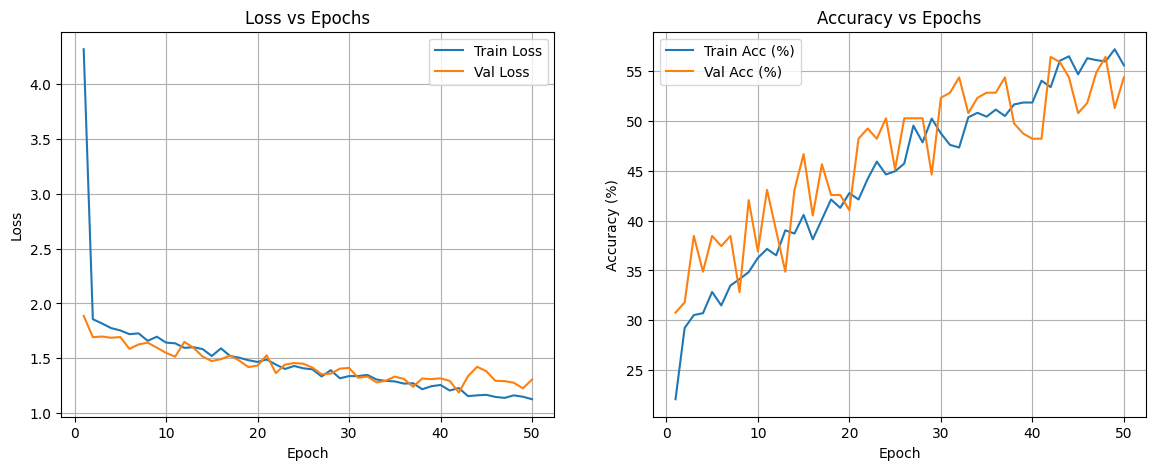

In [ ]:
import matplotlib.pyplot as plt
model = Model1(nb_classes = 8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
NUM_EPOCHS  = 50
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, data_loader_train, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, data_loader_val, criterion, device)

    # On stocke les métriques
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, train_acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, val_cc: {val_acc*100:.2f}%"
    )

    # Sauvegarde du meilleur modèle sur la validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "CNN_oralyze_best.pth")
 

# =======================
#   COURBES D’APPRENTISSAGE
# =======================

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

# ---- Courbe Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)

# ---- Courbe Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.show()

# Sauvegarde du modèle

In [17]:
model.load_state_dict(torch.load("CNN_oralyze_best.pth", map_location=device))


<All keys matched successfully>

# Evaluation du modèle sur le jeu de test

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in data_loader_test:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
class_names = dataset.classes
print("Classes :", class_names)

Classes : ['HERPES SIMPLEX ', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']


# Matrice de confusion

Matrice de confusion (brute) :
 [[ 6  1  0  0  4  1  3  1]
 [ 0 32  0  1 12  1  0  0]
 [ 0  1  0  3  9  2  0  0]
 [ 2 14  0  0  9  1  0  0]
 [ 4  7  0  1 23  3  0  0]
 [ 0 11  0  0 10  3  0  0]
 [ 1  0  0  0  0  0  3  0]
 [ 0  2  0  0  0  1  0 22]]


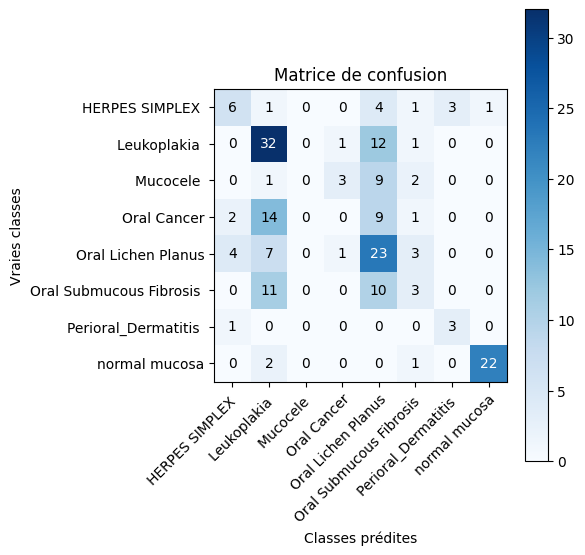

In [20]:
cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()